In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
plt.style.use('seaborn')
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.facecolor'] = "w"


In [5]:
# load opsim database
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases

# output directory
outDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir'
#resultsDb = db.ResultsDb(outDir=outDir)


In [7]:
# get the name of all opsim dbs
workpath = os.getcwd()
os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps/'
os.chdir(workpath) # change back to work directory
dblist_all.sort()


In [8]:
dblist_all[5:6]

['baseline_v1.5_10yrs.db']

In [9]:
ls

LMC_SMC_coverage.ipynb
dT_skymap.ipynb
dT_skymap_all.ipynb
data/
depth_wfd_ms.ipynb
df_Nfields_LMC_inwfd.csv
df_Nfields_allsky.csv
df_Nfields_footprint_big_wfdv1.5_10yrs.db.csv
df_Nfields_wfd.csv
df_Nfields_wfd_v1.5.csv
df_Nstar_LMC_inwfd.csv
df_Nstar_allsky.csv
df_Nstar_wfd.csv
df_Nstars_footprint_big_wfdv1.5_10yrs.db.csv
df_Nstars_wfd_v1.5.csv
df_rank_t.csv
df_tgapsFoM_LMC_inwfd.csv
df_tgapsFoM_footprint_big_wfdv1.5_10yrs.db.csv
df_tgapsFoM_wfd_v1.5.csv
figures/
filterPairTGapsMetric.ipynb
footprintFoM.ipynb
history/
minisurvey_footprint.ipynb
normalize.ipynb
plot_barh.ipynb
plot_barh_allsky.ipynb
plot_barh_minisurvey_allsky.ipynb
plot_barh_minisurvey_inwfd.ipynb
plot_barh_wfd.ipynb
plot_fig34.ipynb
plot_footprint.ipynb
plot_opsim_footprint.ipynb
plot_parallel_compare.ipynb
plot_radar_parallel.ipynb
starDens16.npz
star_density_map.ipynb
star_density_map_fromWill.ipynb
tgaps_minisurvey-GP.ipynb
tgaps_minisurvey.ipynb
tgaps_wfd_noddf.ipynb


In [19]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
cols_all = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

cols_same = [ 'uu',  'gg',  'rr',  'ii',  'zz',  'yy']

cols_diff = ['ug', 'ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy']


In [10]:
def get_df_norm(df=[], cols=['u'], fomcsv = 'df_tgapsFoM_GP.csv'):
    """return normalized dataframe
    cols: columns to normalize
    """
    
    if len(df)!=0:
        df_fom = df.copy()
    else:
        df_fom = pd.read_csv(fomcsv)
    
    if 'db' not in df_fom.columns:
        df_fom['db'] = dblist_all
        
    # scale fom table to 0 and 1
    df_new = df_fom[ ['db', 'prop'] ].copy()
    
    for col in cols:
        # df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )
        df_new[col] = scale(df_fom[col]) 
        
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.5_10yrs.db", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.5_10yrs.db", "") )
    
    df_new['family'] = df_new.apply(get_family, axis=1)
    
    return df_new

def scale(arr, mode=0):
    """scale array by max"""
    newarr = arr / arr.max()
    if mode==1:
        newarr = (arr - arr.min()) / (arr.max()-arr.min())
    return newarr

def get_family(df):
    """get family of opsim"""
    
    return df['db'].split('_')[0]



In [11]:
def plot_barh(df_new, colon, byfamily=True, savefig=None, figsize=(8, 30), facecolor="#f1f1f3", title='', **kwargs):
    """barh plot of FoM"""

    df_ = df_new.copy()
    df_['total'] = np.sum(df_[ colon ], axis=1)
    
    # get the max FOM of each family and sort by this
    df_mean_family = df_.groupby(by = "family", as_index=False).max()[['family', 'total']]
    df_ = df_.merge(df_mean_family, on='family', how='left', suffixes=['', '_fmean'],)
    
    df_ = df_.set_index('db')
    if byfamily:
        df_ = df_.sort_values(by=['total_fmean', 'total'], ascending=[True, True])
    else:
        # sort by total only
        df_ = df_.sort_values(by='total', ascending=True)
    
    df_[colon] = df_[colon]/len(colon)
    ax = df_[ colon ].plot.barh(stacked=True, figsize=figsize, **kwargs)
    
    # get positions of hlines
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()['total_fmean'].values - 0.5
        hlines = [hlines, hlines]
        ax.plot((-0.5, 1), hlines, 'k-', linewidth=1, alpha=0.5)
    
    plt.xlabel('normalized score', fontsize=20)
    plt.ylabel('')
    plt.legend(loc='lower right', frameon=True)
    plt.xlim([0,1.01])
    
    #ax = plt.gca()
    ax.set_facecolor(facecolor)
    ax.set_title(title)
    if savefig!=None:
        plt.savefig(savefig, bbox_inches='tight')


def get_mycmap(pairs='diff'):
    """discrete colormap for filter pairs"""
    import numpy as np
    import matplotlib.colors as mcolors
    
    # colors in total
    # combine them and build a new colormap

    thecbases = [plt.cm.Blues,
                 plt.cm.Greens,
                 plt.cm.Purples,
                 plt.cm.Reds,
                 plt.cm.YlOrBr,
                 (240./255,230./255,140./255, 1.),
                ]

    grad = [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    
    #thecmaps = {'diff': , [thecbases[i](np.linspace(0, 1, 8-i)[::-1][1:]) for i in range(5)]
    #                'same':[thecbases[i](np.linspace(0, 1, 7-i)[-3 if i < 2 else -2]) 
    #                     for i in range(5)] + [thecbases[5]]}
    
    thecmaps = {'diff': [ grad[i] [ 1:6 - i ] for i in range(5) ] ,
                'same':[ grad[i] [ 1 if i!=5 else 0 ] for i in range(5) ] + [thecbases[5]]}
    
    colors = np.vstack( [c for c in thecmaps[pairs]] )
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
            
    #plt.pcolor(data, cmap=mymap)
    #plt.colorbar()
    #plt.show()
    return mymap



In [24]:
df_all = pd.read_csv("./data/df_tgapsFoM_allsky.csv")

if 'db' not in df_all.columns:
    df_all['db'] = dblist_all

df_all.to_csv("./data/df_tgapsFoM_allsky.csv")

In [15]:

df_wfd = pd.read_csv("./data/df_tgapsFoM_wfd.csv")
df_all = pd.read_csv("./data/df_tgapsFoM_allsky.csv")

if 'db' not in df_all.columns:
    df_all['db'] = dblist_all

df_wfd['prop'] = 'wfd'
df_all['prop'] = 'all'

df_wfd = df_wfd.set_index('db')
df_all = df_all.set_index('db')


df = pd.concat([df_wfd, df_all])

df = df.reset_index()

In [16]:
df

,db,uu,ug,ur,ui,uz,uy,gg,gr,gi,...,ri,rz,ry,ii,iz,iy,zz,zy,yy,prop
0,agnddf_v1.5_10yrs.db,10773.203215,8211.584577,17053.204722,5794.473981,NaN,6.743981,20040.485143,23046.227400,7232.683657,...,32424.668130,4930.500669,847.789379,7.281296e+04,31460.153334,13141.707376,7.579293e+04,39081.724304,70556.829527,wfd
1,alt_dust_v1.5_10yrs.db,12341.104839,10034.017207,18406.773689,6662.479995,NaN,1.255707,24332.448925,25704.484239,11156.369018,...,38470.818571,8306.540787,2113.554299,7.014751e+04,37904.224858,21952.694156,6.714988e+04,50707.074846,47672.487777,wfd
2,alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db,12946.487613,12122.253436,19333.891292,6643.910044,NaN,1.680488,25198.530019,27676.867361,12179.515252,...,48244.921803,11393.436117,3322.109223,7.703816e+04,41835.022812,25221.377186,7.795149e+04,55995.778793,51681.402898,wfd
3,baseline_2snaps_v1.5_10yrs.db,12316.289497,7215.969192,14165.567066,4523.946055,NaN,0.369482,22573.222853,21549.385923,6668.007481,...,28973.545276,4673.657595,1069.298398,6.650612e+04,30875.305589,14568.925900,6.873746e+04,39682.776446,60924.566688,wfd
4,baseline_samefilt_v1.5_10yrs.db,24512.619412,877.481570,1484.329861,860.416501,NaN,188.943117,30871.510283,2500.650303,1972.748941,...,8182.692798,1663.785336,1120.463298,5.917988e+04,4141.291747,2234.902257,7.319468e+04,6570.595281,99396.887519,wfd
5,baseline_v1.5_10yrs.db,11160.552213,8527.314295,16764.323853,5654.886869,NaN,0.114204,26282.772876,24221.060560,7729.310184,...,32059.835876,5818.518207,1367.111606,5.916743e+04,33271.965745,17713.650884,5.853088e+04,43833.804014,67945.187363,wfd
6,bulges_bs_v1.5_10yrs.db,8925.009590,6712.092150,12592.797606,3716.355642,NaN,0.023803,21601.674983,18216.669925,5540.038807,...,25244.206588,4091.953514,841.027523,4.721176e+04,25666.580879,12803.156484,4.687714e+04,33782.502100,70082.655059,wfd
7,bulges_bulge_wfd_v1.5_10yrs.db,11272.932227,6442.925598,12886.682898,3861.398400,NaN,0.070410,20758.417778,17760.604271,5434.079681,...,24542.446506,3980.249624,767.188547,4.633244e+04,25470.819787,13000.785495,4.621236e+04,33419.046230,69454.574781,wfd
8,bulges_cadence_bs_v1.5_10yrs.db,11484.494878,6685.031192,12526.437116,3958.005731,NaN,11.160749,21785.436984,18168.310739,5627.573263,...,25606.449324,4372.754693,885.473703,4.535468e+04,25767.266930,12675.475218,4.723687e+04,33038.869572,71122.686208,wfd
9,bulges_cadence_bulge_wfd_v1.5_10yrs.db,11109.606995,6656.696114,12121.286378,3904.676336,NaN,2.526806,22307.805134,17719.659608,5536.232303,...,24967.650615,4443.636487,772.136076,4.603185e+04,25388.409613,12571.021509,4.521904e+04,33093.464686,71086.309887,wfd


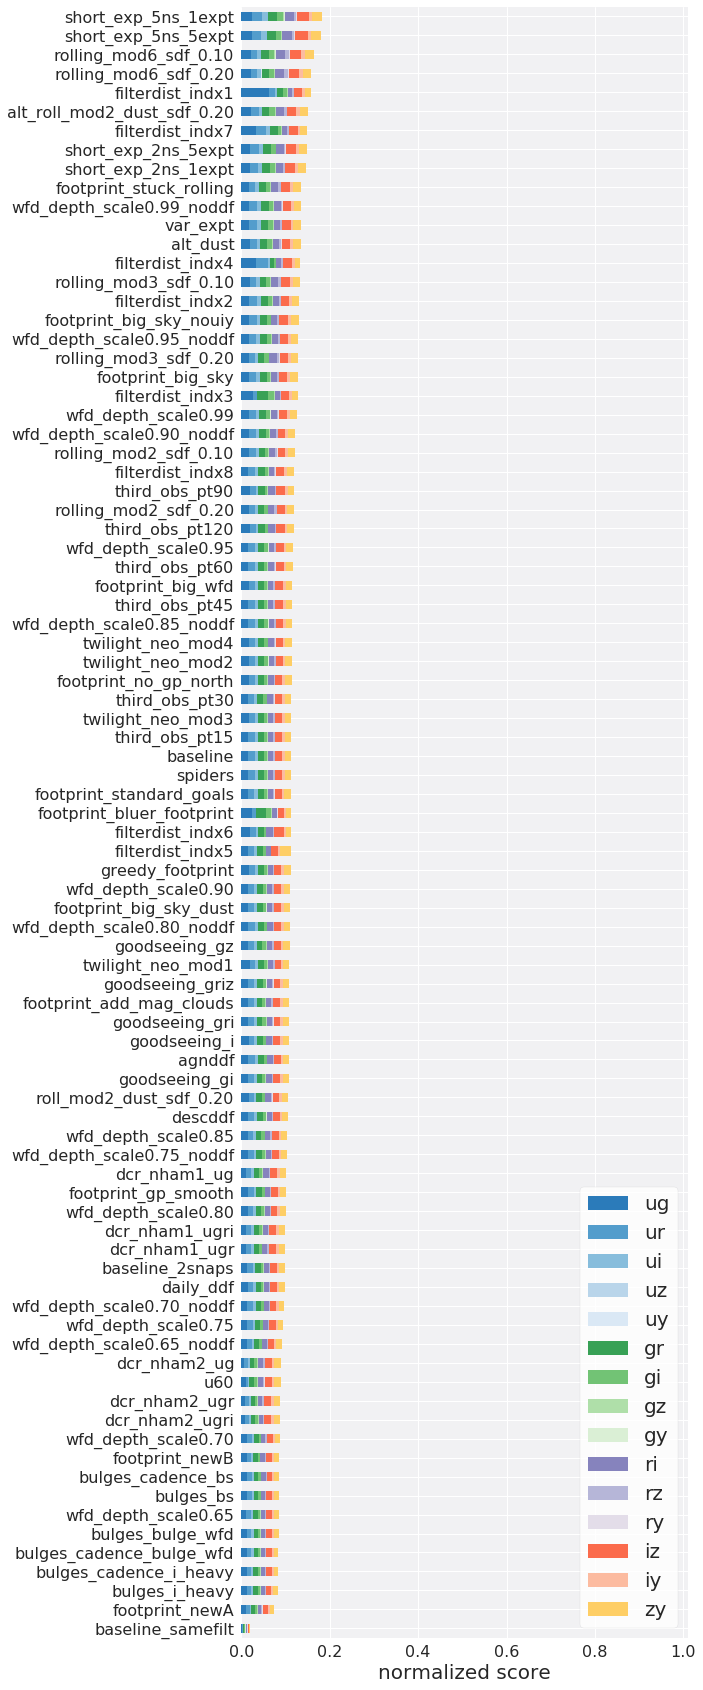

In [22]:
df_norm = get_df_norm(df=df, cols=cols_all)

plot_barh(df_norm[df_norm.prop=='wfd'], colon=cols_diff, byfamily=False, savefig=None, cmap=get_mycmap(pairs='diff') )




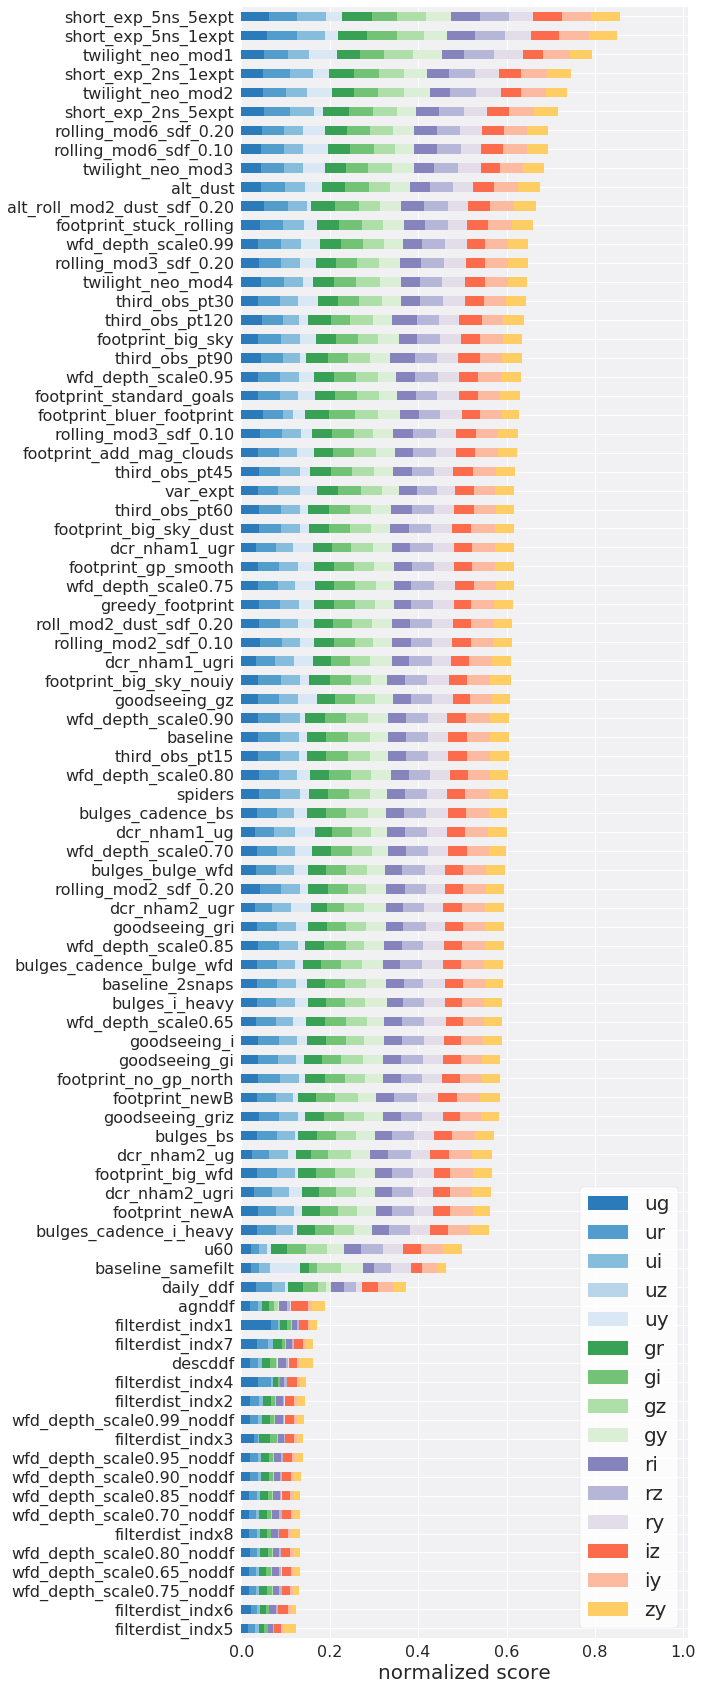

In [23]:
df_norm = get_df_norm(df=df, cols=cols_all)

plot_barh(df_norm[df_norm.prop=='all'], colon=cols_diff, byfamily=False, savefig=None, cmap=get_mycmap(pairs='diff') )


In [ ]:
plot_barh(df_norm[df_norm.prop=='wfd'], colon=cols_all, byfamily=False, savefig=None, cmap=get_mycmap(pairs='diff') )
